In [18]:
import pandas as pd
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from tqdm import tqdm

In [3]:
df = pd.read_csv('../../data/curated/individual_property_final.csv')
df.isnull().sum()

Address                             0
Cost                            18513
Property Type                       0
Bedrooms                            0
Bathrooms                           0
Latitude                            0
Longitude                           0
Closest Gov Secondary School        0
Age under 20                        0
Age 20-39                           0
Age 40-59                           0
Age 60+                             0
Postcode                            0
CBD Distance                        0
Train Distance                      0
Electricity Distance                0
Hospital Distance                   0
Library Distance                    0
Park Distance                       0
Tourist Attraction Distance         0
Grocery Distance                    0
Year                                0
SA2_CODE21                          0
Population                          0
Income                              0
LGA_CODE24                          0
Incidents Re

In [4]:
# Select features for predicted
df = df.drop(columns=['Address', 'Latitude', 'Longitude', 'Postcode', 'SA2_CODE21', 'LGA_CODE24', 'Suburb'], axis=1)

categorical_columns = ['Property Type','Closest Gov Secondary School']
# Apply LabelEncoder to each categorical column
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [5]:
df_train = df[(df['Year'] >= 2015) & (df['Year'] <= 2024)]
df_predict = df[(df['Year'] >= 2025) & (df['Year'] <= 2027)]

In [6]:
X = df_train.drop(columns=['Cost'])
y = df_train['Cost']

In [7]:
seed = 37 

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed)

In [9]:
# Initialize the XGBoost Regressor model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=seed)

# Train the model on the training data
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=37, ...)

In [10]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_val)


In [11]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'RMSE: {rmse}')
r2 = r2_score(y_val, y_pred)
print(f'R²: {r2}')


RMSE: 51.40598335950016
R²: 0.8882660024209517


In [12]:
# XGB with tuning

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.1, 1, 10]
}


In [13]:
# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(
    objective='reg:squarederror', 
    device = "cuda", # uncomment this line if you got ok graphic card
    random_state=seed)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100,  # Reduce iterations for testing
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=2,  # Set higher verbosity to see progress in console
    random_state=seed,
    n_jobs=1 # adjust this based on your cpu capacity, use 1 if unsure
)


In [14]:
# # Fit the model, uncomment this block if you willing to tune again, i have recorded best tuning result
# random_search.fit(X_train, y_train) 

# # Output the best hyperparameters and RMSE
# print(f'Best parameters: {random_search.best_params_}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\Steven\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:33:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=400, reg_alpha=0.1, reg_lambda=0.1, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=400, reg_alpha=0.1, reg_lambda=0.1, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=400, reg_alpha=0.1, reg_lambda=0.1, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=400, reg_alpha=0.1, reg_lambda=0.1, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=400, reg_alpha=0.1, reg_lambda=0.1, subsample=0.6; total time=   0.6s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=10, n_estimators=300, reg_alpha=0.1, reg_lambda=0.1, subsample=0.6; total time=   2.7s
[CV] END colsample_bytree=0.8, gamma=0.1, learning_

Best parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 1.0} \
Use this for our model

In [15]:
# best_xgb_model = random_search.best_estimator_ # uncomment this if you want to run the tuning process
best_xgb_model = XGBRegressor(
    subsample=0.8,
    reg_lambda=1,
    reg_alpha=0.1,
    n_estimators=400,
    max_depth=7,
    learning_rate=0.2,
    gamma=0.1,
    colsample_bytree=1.0,
    random_state=seed
)
print(random_search.best_estimator_)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=37, ...)


In [16]:
# Make predictions on the test set
y_pred = best_xgb_model.predict(X_val)
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f'RMSE: {rmse}')
r2 = r2_score(y_val, y_pred)
print(f'R²: {r2}')

RMSE: 31.763969032558155
R²: 0.9573393446903851


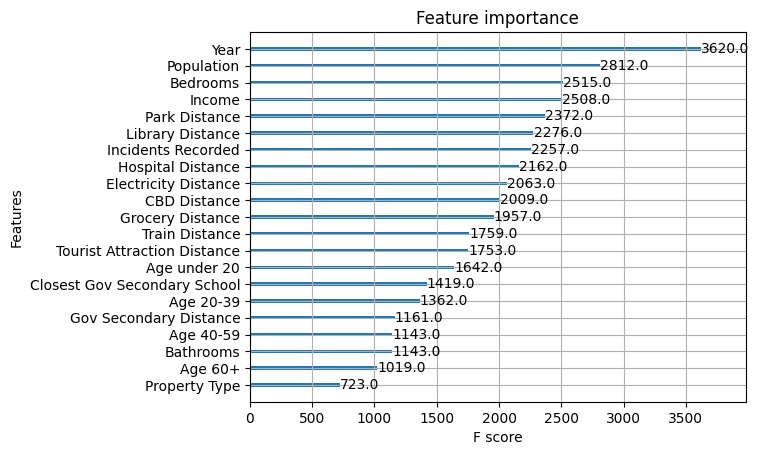

In [19]:
# Feature importance scores
importance = best_xgb_model.feature_importances_

# Plotting the feature importance
xgb.plot_importance(best_xgb_model, importance_type='weight')
plt.show()

In [162]:
# This looks too high, check overfit

y_train_pred = best_xgb_model.predict(X_train)

# Make predictions on the validation set
y_val_pred = best_xgb_model.predict(X_val)

# Calculate RMSE for training set
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(f'Training RMSE: {rmse_train}')

# Calculate RMSE for validation set
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f'Validation RMSE: {rmse_val}')

Training RMSE: 19.884556073039885
Validation RMSE: 37.226658028971656


As this model got best RMSE, use this to predict future price

In [163]:
df = pd.read_csv('../../data/curated/individual_property_final.csv')

In [164]:
# Make predictions for the 3 future years
X_predict = df_predict.drop(columns=['Cost'])
predicted_cost = best_xgb_model.predict(X_predict)


In [165]:
# Combine back to full dataset
df_full = pd.concat([df_train, df_predict], ignore_index=True)

In [166]:
df_train = df[(df['Year'] >= 2015) & (df['Year'] <= 2024)]
df_predict = df[(df['Year'] >= 2025) & (df['Year'] <= 2027)]

In [167]:
df_predict = df_predict.drop(columns=['Cost'])
df_predict['Cost'] = predicted_cost
df_full = pd.concat([df_train, df_predict], ignore_index=True)

In [168]:
# Save df_predict to a CSV file
df_predict.to_csv('../../data/curated/prediction_25_to_27.csv', index=False)
df_full.to_csv('../../data/curated/final_with_predictions_15_to_27.csv', index=False)